In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import time 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32


cuda:0


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.2 MB/s eta 0:00:00


# Download the data from a GitHub repo.

In [3]:
!mkdir data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/drugbank_K_prot.data
!mv drugbank_K_prot.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/drugbank.csv.zip
!mv drugbank.csv.zip data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/drugbank_train_arr.data
!mv drugbank_train_arr.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/drugbank_test_arr.data
!mv drugbank_test_arr.data data/

In [4]:
import pandas as pd
import zipfile
base_name = 'drugbank'
zf = zipfile.ZipFile('data/' + base_name + '.csv.zip') 
df = pd.read_csv(zf.open(base_name + '.csv'),low_memory=False)
df.head()

,uniprot,DBid,smiles,ind2mol,fasta,ind2prot,inter
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,213,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,686,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
2,A1L3X4,DB12965,[Ag],4672,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,462,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,4467,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1


In [5]:
df_p = df[df['inter'] == True]
#list of smiles strings
dict_ind2smiles = df[['ind2mol','smiles']].set_index('ind2mol').to_dict()['smiles']
# ordonner les indices suivant les ind2mol
dict_ind2smiles = {k:dict_ind2smiles[k] for k in sorted(dict_ind2smiles.keys())}
print(len(dict_ind2smiles))
smiles = list(dict_ind2smiles.values())
len(smiles)

4814


4814

# mol kernel
Compute all Morgan Fingerprints.

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
import progressbar
nM =  len(smiles)
MorganFP = np.zeros((nM,1024))
for i in progressbar.progressbar(range(nM)):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles[i])   
    # Generate Morgan fingerprint of the molecule
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    # Convert the fingerprint to a numpy array
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    MorganFP[i,:] = arr

MorganFP = MorganFP.astype(int)

 45% (2194 of 4814) |#########           | Elapsed Time: 0:00:00 ETA:   0:00:00[07:40:37] Unusual charge on atom 0 number of radical electrons set to zero
100% (4814 of 4814) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [7]:
# go to GPU to compute the kernel
MorganFP = torch.tensor(MorganFP, dtype=mytype).to(device)

Select a random subset $S$ of $k$ molecules.

In [17]:
k = nM # number of molecule to compute nystrom
rM = nM #2000 # final dimension of features for molecules
S = np.random.permutation(nM)[:k]
S = np.arange(0,nM,1)
S

array([   0,    1,    2, ..., 4811, 4812, 4813])

Compute Tanimoto kernel between $S$ and all the molecules. When viewed as vectors of $\{0,1\}$ $x=1_A$, $y=1_B$, the formula is 
$$
  K(x,y) = \frac{|A \cap B|}{|A \cup B|}
  = \frac{|A \cap B|}{1024 - |A^c \cap B^c|}
  = \frac{\langle x,y \rangle}{1024 - \langle 1-x,1-y \rangle}
$$

In [18]:
tic = time.perf_counter()
K = ( MorganFP[S,:] @ MorganFP.T ) / ( 1024 - (1-MorganFP[S,:]) @ (1-MorganFP.T) )
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

time: 3.3282 seconds


In [19]:
K.shape

torch.Size([4814, 4814])

Apply Nyström

time: 23.0376 seconds


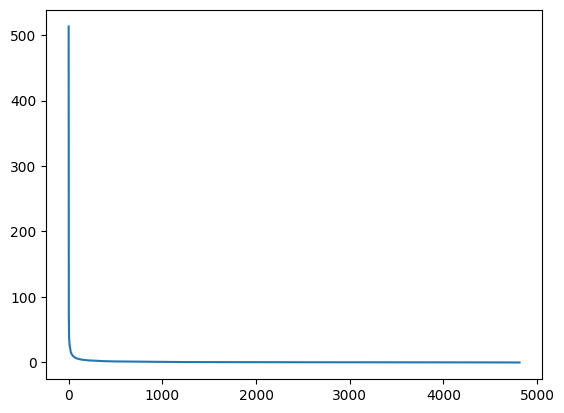

In [20]:
tic = time.perf_counter()
U, Lambda, VT = torch.svd(K[:,S])
epsi = 1e-8  # be careful when we divide by Lambda near 0
X = K.T @ U[:,:rM] @ torch.diag(1./torch.sqrt(epsi + Lambda[:rM]))
print(f"time: {time.perf_counter() - tic:0.4f} seconds")
plt.plot(Lambda.cpu())

In [21]:
X.shape

torch.Size([4814, 4814])

Normalise X

In [22]:
X_c = X - X.mean(axis = 0)
X_cn = X_c / torch.norm(X_c,dim = 1)[:,None] 

# prot kernel

Load protein kernel and compute its features $Y$.

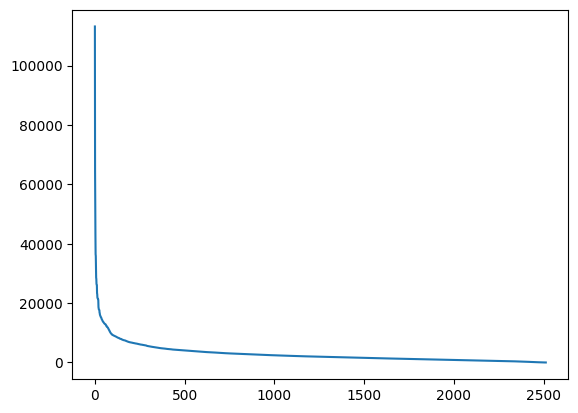

In [23]:
import pickle
with open('data/drugbank_K_prot.data', 'rb') as f:
  KP = pickle.load(f)
KP = torch.tensor(KP, dtype=mytype).to(device)
# computation of feature for protein (no nystrom, just PCA)
rP = KP.shape[0]#min(KP.shape[0],500)
U, Lambda, VT = torch.svd(KP)
Y = U[:,:rP] @ torch.diag(torch.sqrt(Lambda[:rP]))
torch.norm(KP - Y@Y.T)/torch.norm(KP)
plt.plot(Lambda.cpu())

Normalise Y

In [24]:
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]

# train

In [27]:
# load with pickle
import pickle
with open('data/drugbank_train_arr.data', 'rb') as f:
        train_arr = pickle.load(f)

print(len(train_arr))
print(len(train_arr[0]))
i_arr = 0
train = train_arr[i_arr]

5
21944


In [28]:

J0 = train[:,0] # proteins
I0 = train[:,1] # molecules
y = train[:,2] # labels
print(len(I0))

21944


In [29]:
# sub-select those I and J within the loaded database
I = I0[I0<nM]
J = J0[I0<nM]
y = y[I0<nM]
I = torch.tensor(I, dtype=torch.long).to(device)
J = torch.tensor(J, dtype=torch.long).to(device)
y = torch.tensor( np.sign(y-.5) ).to(device)
n = len(I)
print(n)

21944


In [30]:
# compute the features of the Kronecker kernel for the train
XI, YJ = X_cn[I,:], Y_cn[J,:]
def U(w): return torch.sum( (YJ@w) * XI, axis=1 )
def U(w): return torch.sum( (Y_cn@w)[J,:] * XI, axis=1 ) # FAST
def UT(z): return YJ.T @ ( z[:,None] * XI )  # TODO : modify this

In [31]:
# a comparison of 2 ways to apply YJ

w = torch.randn(rP,rM).to(device)

tic = time.perf_counter()
z = torch.sum( (YJ@w) * XI, axis=1 )
a = torch.norm(z).item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
z = torch.sum( (Y@w)[J,:] * XI, axis=1 )
a = torch.norm(z).item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")


time: 0.1910 seconds
time: 0.0319 seconds


In [32]:
w = torch.randn(rP,rM).to(device)
z = torch.randn(n).to(device)

tic = time.perf_counter()
z = U(w)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
z = U(w)
z[0].item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
w = UT(z)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

time: 0.0004 seconds
time: 0.0380 seconds
time: 0.0004 seconds


In [33]:
!nvidia-smi

Thu Apr  6 07:45:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    70W /  70W |   3111MiB / 15360MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
def Loss(u): return 1/n * torch.sum(torch.maximum(1+u,torch.tensor(0)))
lamb = 1e-05
def g(w,b): return Loss(-y * (U(w)+b)) + lamb/2 * (w**2).sum() 

In [35]:
# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = g(w_bfgs,b_bfgs)
    objective.backward()
    return objective

w_bfgs = torch.randn(rP,rM).to(device)
b_bfgs = torch.randn(1).to(device)
w_bfgs.requires_grad = True
b_bfgs.requires_grad = True

lbfgs = optim.LBFGS([w_bfgs,b_bfgs],
                    history_size=10,
                    max_iter=4,
                    line_search_fn="strong_wolfe")
niter = 20
history_lbfgs = []
tic = time.perf_counter()
for i in range(niter):
    history_lbfgs.append(g(w_bfgs,b_bfgs).item())
    lbfgs.step(closure)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")
print( g(w_bfgs,b_bfgs) )

time: 7.1679 seconds
tensor(0.1631, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


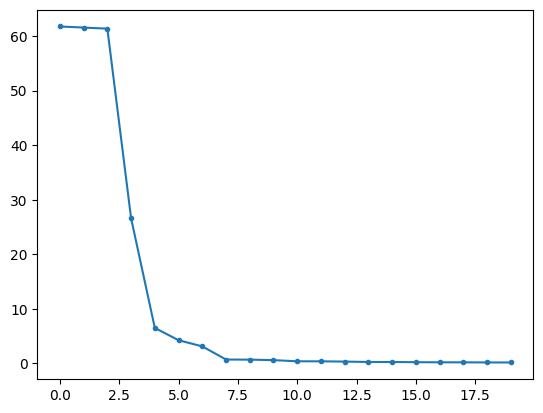

In [36]:
plt.plot( torch.tensor( history_lbfgs ), '.-' );

In [37]:
# prediction
with open('data/drugbank_test_arr.data', 'rb') as f:
        test_arr = pickle.load(f)
test = test_arr[i_arr]
J0_test = test[:,0] # proteins  #IP_test
I0_test = test[:,1] # molecules IM_test
y_test = test[:,2] # labels

# sub-select those I and J within the loaded database
I_test = I0_test[I0_test<nM]
J_test = J0_test[I0_test<nM]
y_test = y_test[I0_test<nM]
I_test = torch.tensor(I_test, dtype=torch.long).to(device)
J_test = torch.tensor(J_test, dtype=torch.long).to(device)
y_test = torch.tensor( np.sign(y_test-.5) ).to(device)
n_test = len(I_test)
print(n_test)

5488


Test if no pairs in train and test

In [38]:
#I_test = I_test.type(torch.long)
#J_test = J_test.type(torch.long)

# compute the features of the Kronecker kernel
XI_test = X_cn[I_test,:].to(device)
YJ_test = Y_cn[J_test,:].to(device)
print(XI_test.shape,YJ_test.shape)

def U_test(w): 
  #w = w.reshape(rP,rM)
  return torch.sum( (Y_cn@w)[J_test,:] * XI_test, axis=1 )

pr_f = torch.sign( U_test(w_bfgs).detach() + b_bfgs.detach() )

torch.Size([5488, 4814]) torch.Size([5488, 2513])


In [39]:
print("accuracy", torch.sum( y_test == pr_f ) / len(y_test) )

accuracy tensor(0.8723, device='cuda:0')


Plot accuracy in function of lambda

In [65]:
# calculate accuraccy for differetn lmabda
lambdas = np.logspace(-12, 3, num=16)
accs = []
for lamb in lambdas:
  def g(w,b): return Loss(-y * (U(w)+b)) + lamb/2 * (w**2).sum() 

  # L-BFGS
  def closure():
      lbfgs.zero_grad()
      objective = g(w_bfgs,b_bfgs)
      objective.backward()
      return objective

  w_bfgs = torch.randn(rP,rM).to(device)
  b_bfgs = torch.randn(1).to(device)
  w_bfgs.requires_grad = True
  b_bfgs.requires_grad = True

  lbfgs = optim.LBFGS([w_bfgs,b_bfgs],
                      history_size=10,
                      max_iter=4,
                      line_search_fn="strong_wolfe")
  niter = 20
  history_lbfgs = []
  tic = time.perf_counter()
  for i in range(niter):
      history_lbfgs.append(g(w_bfgs,b_bfgs).item())
      lbfgs.step(closure)
  print(f"time: {time.perf_counter() - tic:0.4f} seconds")
  print( g(w_bfgs,b_bfgs) )

  pr_f = torch.sign( U_test(w_bfgs).detach() + b_bfgs.detach() )
  acc = torch.sum( y_test == pr_f ) / len(y_test)
  accs.append(acc.item())
  print("lambda=",lamb,"accuracy=",acc.item())

time: 7.1558 seconds
tensor(0.0006, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-12 accuracy= 0.8314504623413086
time: 6.6117 seconds
tensor(0.0006, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-11 accuracy= 0.8369169235229492
time: 6.7141 seconds
tensor(0.0012, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-10 accuracy= 0.8241618275642395
time: 7.2595 seconds
tensor(0.0068, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-09 accuracy= 0.8268950581550598
time: 7.2088 seconds
tensor(0.0612, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-08 accuracy= 0.8299927711486816
time: 7.2321 seconds
tensor(0.4038, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-07 accuracy= 0.8378280401229858
time: 7.3821 seconds
tensor(0.3597, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-06 accuracy= 0.8573250770568848
time: 7.2946 

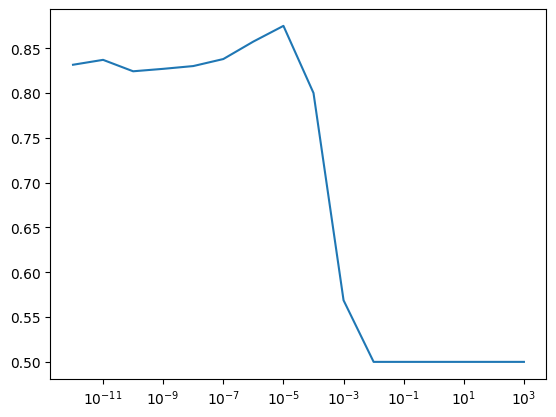

In [66]:
plt.plot(lambdas,accs)
plt.xscale('log')
plt.show()

# Platt scaling

Once the weight $w$ have been computed, Platt scaling compute a probability using the formula
$$
    p_i := \sigma(-y_i ( s \langle x_i,w \rangle + t ))
    \text{ where }
    \sigma(u)=\frac{e^u}{1+e^u}
$$
where the scale $s$ (leven of confidence in some sense) and offset $t$ needs to be optimized. They are found by minimlizing the same energy as the logistic classification.
$$
    \min_{s,t} E(s,t) := \sum_i \ell(-y_i ( s \langle x_i,w \rangle + t)) 
    = L( - y \odot (s m  + t ) )
$$
where $\ell(u) := \log( 1 + e^u )$ and $m:=Xw$.

In [40]:
m = U_test(w_bfgs).detach() # do not forget to detach (do not backprop through it)!

In [41]:
def E(s,t): return 1/n * torch.sum( torch.log( 1+torch.exp(-y_test*(s*m+t)) ) )

In [42]:
# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = E(s,t)
    objective.backward()
    return objective
s = torch.ones(1).to(device)
t = torch.zeros(1).to(device)
s.requires_grad = True
t.requires_grad = True
lbfgs = optim.LBFGS([s,t],
                    history_size=10,
                    max_iter=4,
                    line_search_fn="strong_wolfe")
niter = 20
history_lbfgs = []
for i in range(niter):
    history_lbfgs.append(E(s,t).item())
    lbfgs.step(closure)

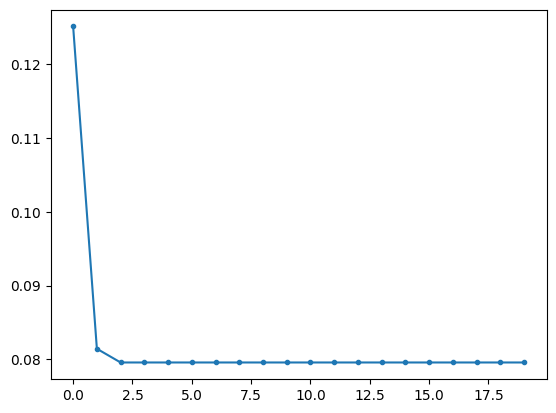

In [43]:
plt.plot( history_lbfgs, '.-' ) 

In [44]:
print(E(s,t))

tensor(0.0796, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


In [45]:
def sigma(u): return torch.exp(u) / (1+torch.exp(u))
p = sigma( (s*m+t) ).detach()

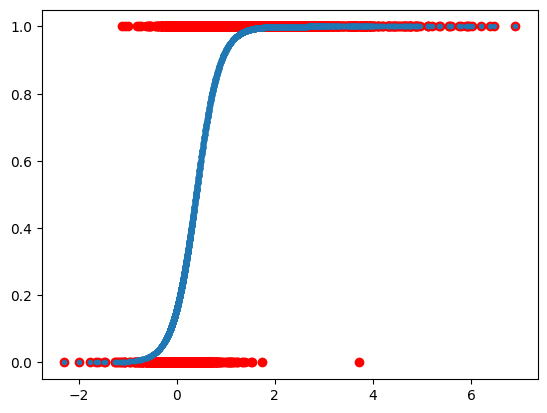

In [46]:
plt.plot( m.cpu().numpy(), (y_test.cpu()+1)/2, 'ro' )

plt.plot( m.cpu().numpy(), p.cpu().numpy(), '.' )

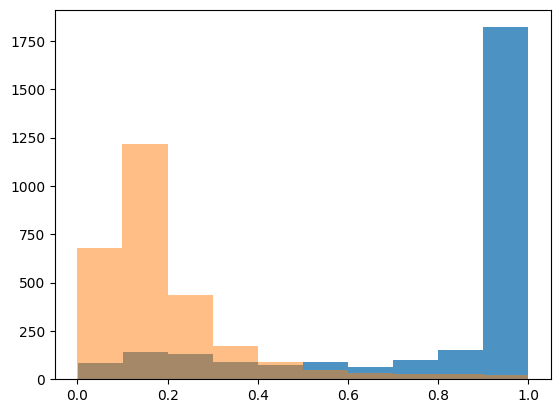

In [47]:
# plot distribution (density) of p when y_test=1
plt.hist(p.cpu().numpy()[y_test.cpu().numpy()==1],bins=10,alpha=0.8);
plt.hist(p.cpu().numpy()[y_test.cpu()==-1],bins=10,alpha=0.5);
plt.show()

Roc AUC

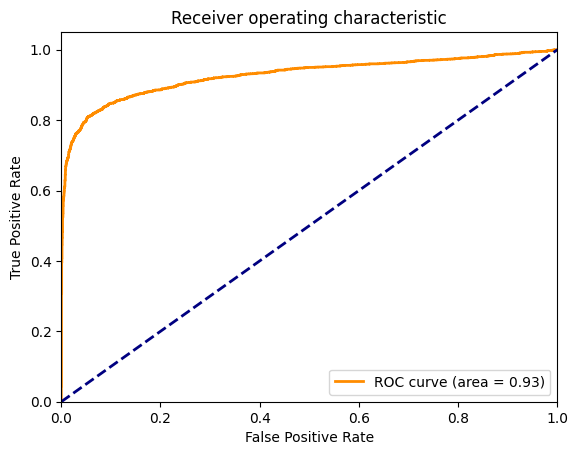

In [56]:
# plot ROC curve et afficher roc auc
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), p.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

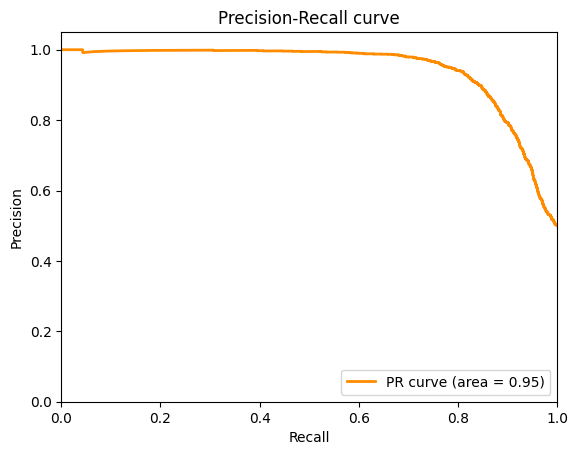

In [55]:
# plot PR curve et afficher AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test.cpu().numpy(), p.cpu().numpy())
average_precision = average_precision_score(y_test.cpu().numpy(), p.cpu().numpy())
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
for elt in train:
    for x in test:
        if elt[0]==x[0] and elt[1]==x[1]:
            print(elt)

5442
5488
